# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 05.11.2020

Мягкий дедлайн: 01:59MSK 18.11.2019

Жесткий дедлайн: 01:59MSK 22.11.2019

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/21899 нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [95]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [96]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

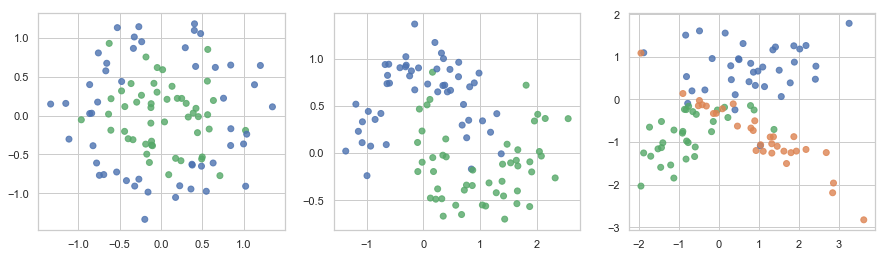

In [97]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [98]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

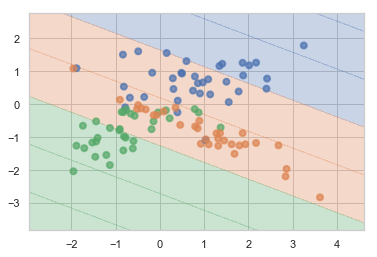

In [99]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [100]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score
def draw_hyperplane(X, y, i):
    # if >2 classes user macro approach to compute precisions and recalls 
    keyword = 'binary'
    if len(np.unique(y)) > 2:
        keyword = 'micro'

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    print(f'{i} dataset')
    y_train_pred = tree.predict(X_train)
    print('Train metrics: precision={}, recall={}'.format(precision_score(y_train, y_train_pred, average=keyword),
                                                          recall_score(y_train, y_train_pred, average=keyword)))
    y_test_pred = tree.predict(X_test)
    print('Test metrics: precision={}, recall={}'.format(precision_score(y_test, y_test_pred, average=keyword),
                                                          recall_score(y_test, y_test_pred, average=keyword)))
    
    # draw surface on test only 
    plot_surface(tree, X_test, y_test)

0 dataset
Train metrics: precision=1.0, recall=1.0
Test metrics: precision=0.8571428571428571, recall=0.9473684210526315


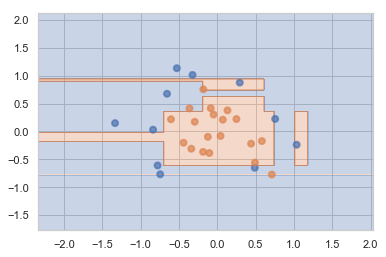

In [101]:
X, y = datasets[0]
draw_hyperplane(X, y, 0)

1 dataset
Train metrics: precision=1.0, recall=1.0
Test metrics: precision=0.7647058823529411, recall=0.9285714285714286


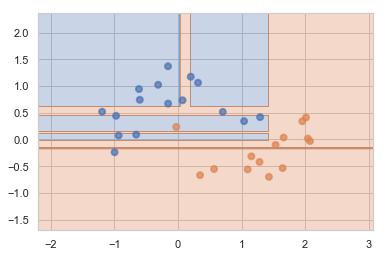

In [102]:
X, y = datasets[1]
draw_hyperplane(X, y, 1)

2 dataset
Train metrics: precision=1.0, recall=1.0
Test metrics: precision=0.8, recall=0.8


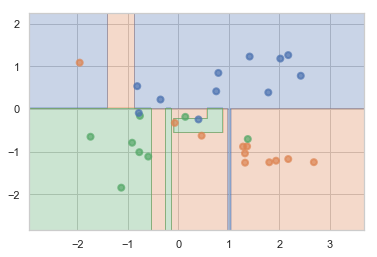

In [103]:
X, y = datasets[2]
draw_hyperplane(X, y, 2)

__Ответ:__  Несмотря на то что метрики на тесте приличные, я бы сказал что деревья переобучились. Какие-то непонятные тоненькие прямоугольники на первых двух рисунках, рандомный зелёный прямоугольник на третьем – всё это симптомы переобучения. Думаю если бы датасеты были побольше, то значения метрик были бы намного хуже

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [135]:
# первый датасет
X, y = datasets[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

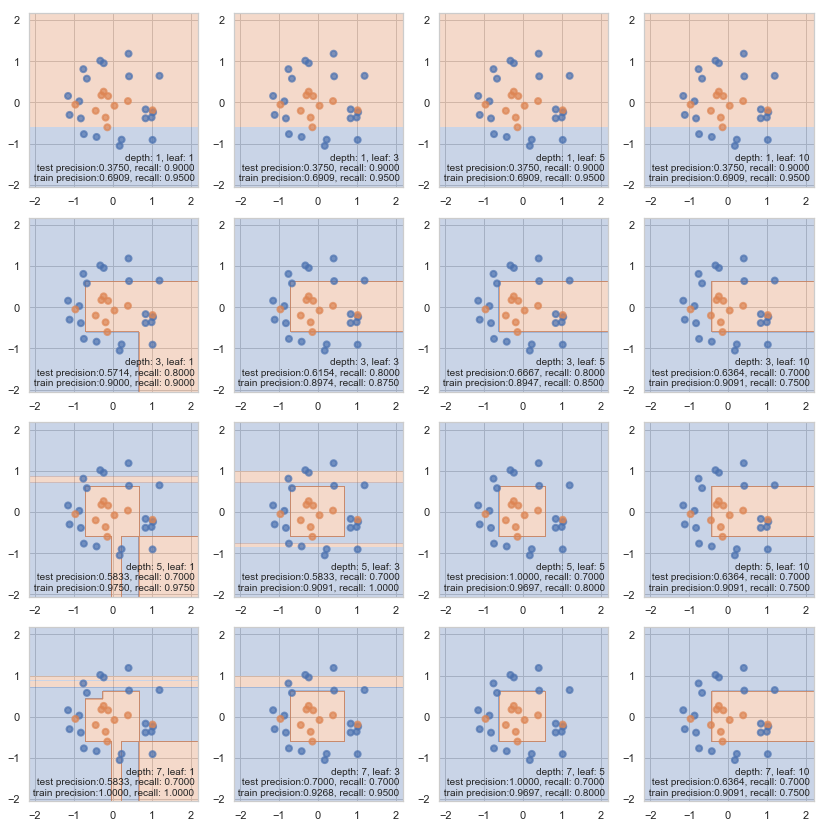

In [136]:
plt.figure(figsize=(12, 12))
depth_space = [1, 3, 5, 7]
leaf_samples_space = [1, 3, 5, 10]
# выборка у нас небольшая, больше 10 вряд ли будет иметь смысл выставлять параметры
for i in range(len(depth_space)):
    depth = depth_space[i]
    for j in range(len(leaf_samples_space)):
        leaf_samples = leaf_samples_space[j]
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf_samples)
        tree.fit(X_train, y_train)
        plt.subplot2grid((4, 4), (i, j))
        plot_surface(tree, X_test, y_test)
        pred = tree.predict(X_test)
        pred_train = tree.predict(X_train)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        prec_train = precision_score(y_train, pred_train)
        rec_train = recall_score(y_train, pred_train)
        plt.text(plt.xlim()[1] - 0.1, plt.ylim()[0] + 0.1,
                 'depth: {}, leaf: {}\n test precision:{:.4f}, recall: {:.4f}\n train precision:{:.4f}, recall: {:.4f}'
                 .format(depth, leaf_samples, precision, recall, prec_train, rec_train),
                ha='right',va='bottom')
# plt.show()

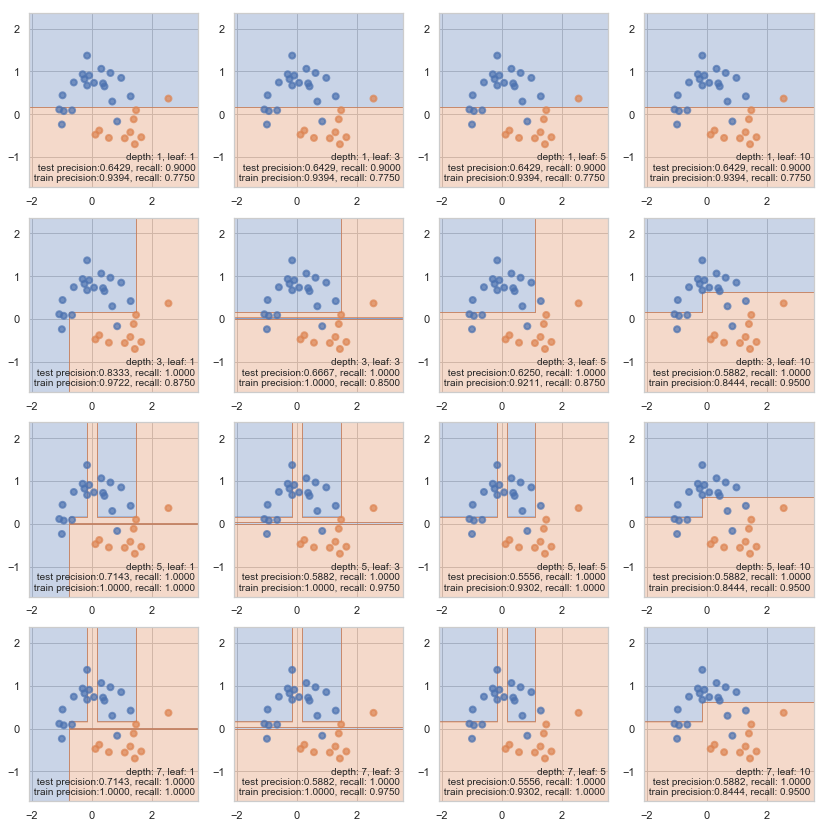

In [137]:
# второй датасет
X, y = datasets[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(12, 12))
depth_space = [1, 3, 5, 7]
leaf_samples_space = [1, 3, 5, 10]
# выборка у нас небольшая, больше 10 вряд ли будет иметь смысл выставлять параметры
for i in range(len(depth_space)):
    depth = depth_space[i]
    for j in range(len(leaf_samples_space)):
        leaf_samples = leaf_samples_space[j]
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf_samples)
        tree.fit(X_train, y_train)
        plt.subplot2grid((4, 4), (i, j))
        plot_surface(tree, X_test, y_test)
        pred = tree.predict(X_test)
        pred_train = tree.predict(X_train)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        prec_train = precision_score(y_train, pred_train)
        rec_train = recall_score(y_train, pred_train)
        plt.text(plt.xlim()[1] - 0.1, plt.ylim()[0] + 0.1,
                 'depth: {}, leaf: {}\n test precision:{:.4f}, recall: {:.4f}\n train precision:{:.4f}, recall: {:.4f}'
                 .format(depth, leaf_samples, precision, recall, prec_train, rec_train),
                ha='right',va='bottom')
# plt.show()

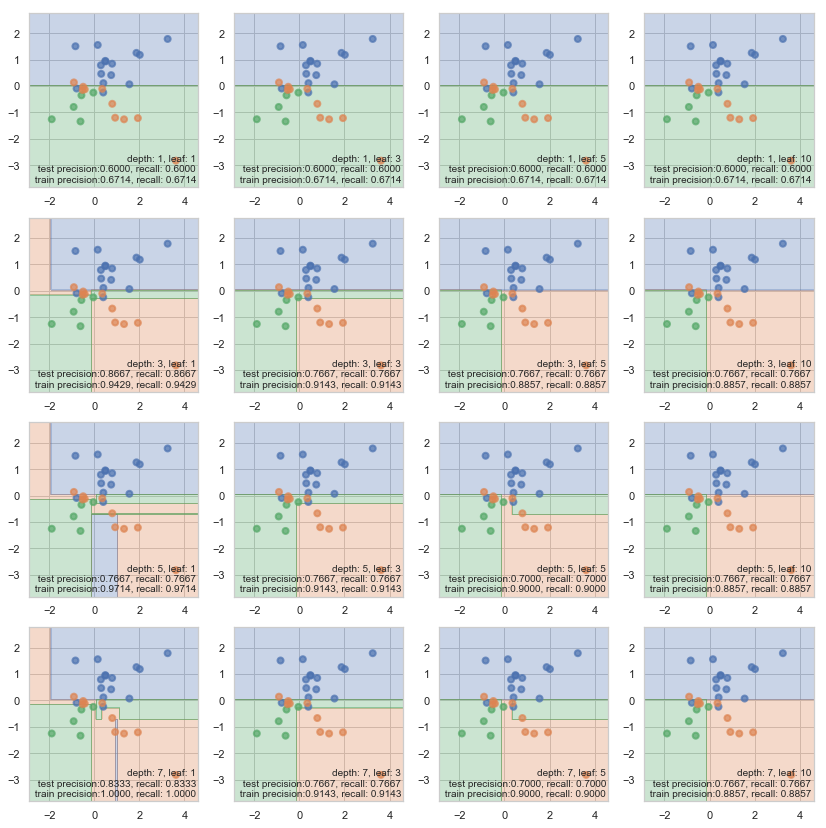

In [138]:
# третий датасет
# тут мультилейбл, precision и recall посчитаем при помощи микро усреднения
X, y = datasets[2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(12, 12))
depth_space = [1, 3, 5, 7]
leaf_samples_space = [1, 3, 5, 10]
# выборка у нас небольшая, больше 10 вряд ли будет иметь смысл выставлять параметры
for i in range(len(depth_space)):
    depth = depth_space[i]
    for j in range(len(leaf_samples_space)):
        leaf_samples = leaf_samples_space[j]
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf_samples)
        tree.fit(X_train, y_train)
        plt.subplot2grid((4, 4), (i, j))
        plot_surface(tree, X_test, y_test)
        pred = tree.predict(X_test)
        pred_train = tree.predict(X_train)
        precision = precision_score(y_test, pred, average='micro')
        recall = recall_score(y_test, pred, average='micro')
        prec_train = precision_score(y_train, pred_train, average='micro')
        rec_train = recall_score(y_train, pred_train, average='micro')
        plt.text(plt.xlim()[1] - 0.1, plt.ylim()[0] + 0.1,
                 'depth: {}, leaf: {}\n test precision:{:.4f}, recall: {:.4f}\n train precision:{:.4f}, recall: {:.4f}'
                 .format(depth, leaf_samples, precision, recall, prec_train, rec_train),
                ha='right',va='bottom')
# plt.show()

**__Ответ__**: для первого датасета с увеличением максимальной глубины дерево не сильно переобучается и улучшает качество (особенно при leaf=5). Во втором и третьем случае дерево здорово учится только при ограничении на листья (10). Думаю это из-за того, как расположены объекты в нашей выборке (в первой облако оранжевых в середине, в остальных двух случаях классы можно определить, поделив плоскость на сектора)

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

https://contest.yandex.ru/contest/21899/run-report/42015039/

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [445]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('/Users/danyasedashov/Downloads/students.csv')

In [446]:
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [447]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [470]:
%autoreload 2
from hw5code import find_best_split

In [449]:
target = df[' UNS'].to_numpy() # кто так признаки называет....................

In [450]:
features = df.drop(columns=' UNS').to_numpy().transpose()

In [471]:
thresholds = [find_best_split(feature, target)[0] for feature in features]

In [472]:
ginis = [find_best_split(feature, target)[1] for feature in features]

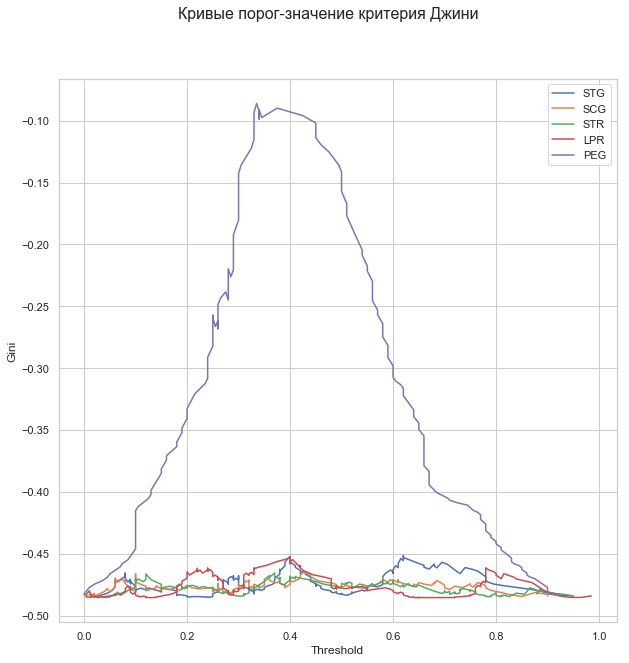

In [473]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(len(thresholds)):
    ax.plot(thresholds[i], ginis[i], label=df.columns[i])
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Gini')
plt.suptitle('Кривые порог-значение критерия Джини', fontsize=16)
plt.show()

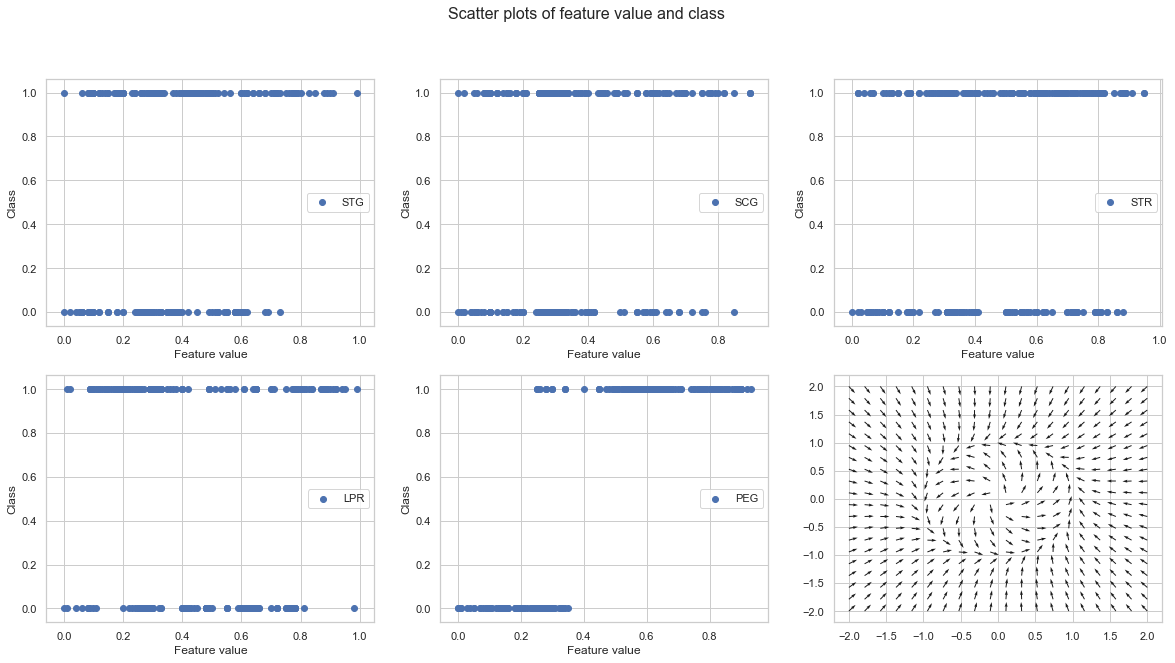

In [474]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i in range(5):
    axs[i // 3][i % 3].scatter(df[df.columns[i]], target, label=df.columns[i])
    axs[i // 3][i % 3].set_xlabel('Feature value')
    axs[i // 3][i % 3].set_ylabel('Class')
    axs[i // 3][i % 3].legend(loc='center right')
    
# заполним лишний график чем нибудь
x, y = np.mgrid[2:-2:20j, 2:-2:20j]
r = np.sqrt(x**2 + y**2)
phi = np.arctan2(y, x)
dr = 5*(r**2)*(1-r)
dphi = r
dx = dr*np.cos(phi) - dphi*np.sin(phi)
dy = dr*np.sin(phi) + dphi*np.cos(phi)
norm_dr = np.sqrt(dx**2 + dy**2)
axs[1][2].quiver(x, y, dx/norm_dr, dy/norm_dr)

plt.suptitle('Scatter plots of feature value and class', fontsize=16)
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** стоит сплиттить по PEG. Этот выбор согласуется и со scatter-графиками. Думаю, хорошая кривая похожа на параболу с положительным коэфф. при квадрате. Кривые для признаков, по которым практически невозможно делить, пологие

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

https://contest.yandex.ru/contest/21899/run-report/42014810/

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [475]:
shr = pd.read_csv('/Users/danyasedashov/Downloads/agaricus-lepiota.data')

In [478]:
for col in shr.columns:
    shr[col] = LabelEncoder().fit_transform(shr[col])

In [479]:
shr.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [517]:
y = shr['p'].to_numpy()
X = shr.drop(columns='p').to_numpy()

In [518]:
X.shape

(8123, 22)

In [521]:
%autoreload 2
from hw5code import DecisionTree

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [523]:
tree = DecisionTree(feature_types=['real'] * X.shape[1])

In [524]:
tree.fit(X_train, y_train)

In [525]:
pred = tree.predict(X_test)

In [526]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_test, pred)}')

Accuracy: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [535]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
tic_tac = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', names=list(range(10)))
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=list(range(7)))
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', names=list(range(9)))

In [536]:
tic_tac.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [537]:
cars.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [538]:
nursery.head()

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [541]:
tic_tac[9] = tic_tac[9].apply(lambda x: 1 if x == 'positive' else 0)
cars[6] = cars[6].apply(lambda x: 1 if x in ['good', 'vgood'] else 0)
nursery[8] = nursery[8].apply(lambda x: 0 if x in ['not_recom', 'recommend'] else 1)

In [542]:
for df in [tic_tac, cars, nursery]:
    for col in df.columns[:-1]:
        df[col] = LabelEncoder().fit_transform(df[col])

In [551]:
# для того чтобы работал cross_val_score надо добавить get_params в класс
%autoreload 2
from hw5code import DecisionTree

In [591]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
# print('All features are real')
names = ['Mushrooms', 'Tic-Tac', 'Cars', 'Nursery']
dfs = [shr, tic_tac, cars, nursery]
res = list()
scores = list()
for i in range(len(dfs)):
    df = dfs[i]
    if i != 0:
        X = df.drop(columns=df.columns[-1]).to_numpy()
        y = df[df.columns[-1]].to_numpy()
    else:
        # shrooms
        X = df.drop(columns=df.columns[0]).to_numpy()
        y = df[df.columns[0]].to_numpy()
    tree = DecisionTree(feature_types=['real'] * X.shape[1])
    acc = cross_val_score(tree, X, y, scoring=make_scorer(accuracy_score), cv=10)
    scores.append(np.mean(acc))
#     print(names[i], 'accuracy :', np.mean(acc))
res.append(scores)

In [592]:
scores = list()
for i in range(len(dfs)):
    df = dfs[i]
    if i != 0:
        X = df.drop(columns=df.columns[-1]).to_numpy()
        y = df[df.columns[-1]].to_numpy()
    else:
        # shrooms
        X = df.drop(columns=df.columns[0]).to_numpy()
        y = df[df.columns[0]].to_numpy()
    tree = DecisionTree(feature_types=['categorical'] * X.shape[1])
    acc = cross_val_score(tree, X, y, scoring=make_scorer(accuracy_score), cv=10)
    scores.append(np.mean(acc))
#     print(names[i], 'accuracy :', np.mean(acc))
res.append(scores)

In [593]:
from sklearn.preprocessing import OneHotEncoder
scores=list()
for i in range(len(dfs)):
    df = dfs[i]
    if i != 0:
        X = df.drop(columns=df.columns[-1]).to_numpy()
        y = df[df.columns[-1]].to_numpy()
    else:
        # shrooms
        X = df.drop(columns=df.columns[0]).to_numpy()
        y = df[df.columns[0]].to_numpy()
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X = ohe.fit_transform(X)
    tree = DecisionTree(feature_types=['real'] * X.shape[1])
    acc = cross_val_score(tree, X, y, scoring=make_scorer(accuracy_score), cv=10)
    scores.append(np.mean(acc))
#     print(names[i], 'accuracy :', np.mean(acc))
res.append(scores)

In [594]:
scores=list()
for i in range(len(dfs)):
    df = dfs[i]
    if i != 0:
        X = df.drop(columns=df.columns[-1]).to_numpy()
        y = df[df.columns[-1]].to_numpy()
    else:
        # shrooms
        X = df.drop(columns=df.columns[0]).to_numpy()
        y = df[df.columns[0]].to_numpy()
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    tree = DecisionTreeClassifier()
    acc = cross_val_score(tree, X, y, scoring=make_scorer(accuracy_score), cv=10)
    scores.append(np.mean(acc))
#     print(names[i], 'accuracy :', np.mean(acc))
res.append(scores)

In [595]:
res = pd.DataFrame(data=np.array(res).transpose(), index=names, columns=['real', 'cat', 'real+OHE', 'sklearn (real)'])

In [596]:
res

,real,cat,real+OHE,sklearn (real)
Mushrooms,0.999261,1.000000,0.999631,0.962716
Tic-Tac,0.467533,0.542500,0.544616,0.730585
Cars,0.942647,0.967546,0.919495,0.940972
Nursery,0.999691,0.999846,0.999537,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** ожидаемо для разных наборов данных алгоритмы ранжируются по-разному. Во-первых, почти везде лучшие результаты показывает подход, в котором мы рассматриваем признаки как категориальные. Это логично, потому что во всех наборах все признаки категориальные, и коли деревья умеют с ними хорошо работать, нет смысла их как-то кодировать. Также заметим что на машинах лучше результаты без OHE. Если посмотреть на признаки, то их можно отранжировать (там везде что-то типа low med high), так что можно воспринимать их значение после LabelEncoder как числовое. В tic-tac-toe же наоборот все признаки чисто категориальные, поэтому OHE работает лучше. 

Про случайность сложно ответить, вроде как +- все результаты объяснимы

Вставьте что угодно, описывающее ваши впечатления от этого задания:

<img src=https://pyxis.nymag.com/v1/imgs/09c/923/65324bb3906b6865f904a72f8f8a908541-16-spongebob-explainer.rsquare.w700.jpg>